In [1]:
# MIT_Image

In [2]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import gzip
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import cmath
import skimage.measure

# data path
path_csi =  'J:\\Data\\Wi-Fi_processed\\'
path_csi_hc = 'J:\\Data\\Wi-Fi_HC\\180_100\\'

# data info
df_info = pd.read_csv('data_subc_sig_v1.csv')
#df_info = df_info[df_info.id_person < 50]
#df_info = df_info[(df_info.id_location==1)  & (df_info.id_direction==1)]

person_uid = np.unique(df_info['id_person'])
dict_id = dict(zip(person_uid,np.arange(len(person_uid))))

# parameters
max_value = np.max(df_info['max'].values)
#no_classes = len(np.unique(df_info['id_person']))
no_classes = len(dict_id)
csi_time = int(np.max(df_info['len']))
csi_subc = 30
input_shape = (csi_time, csi_subc, 6)

C:\Users\herok\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# make data generator
def gen_csi(df_info,id_num,len_num):
    for file in np.unique(df_info.id.values):
        # read sample data
        # load and uncompress.
        with gzip.open(path_csi+file+'.pickle.gz','rb') as f:
            data1 = pickle.load(f)
        data1_diff = data1 #np.diff(data1,axis=0)
        # zero pad
        pad_len = len_num - data1_diff.shape[0]
        data1_pad = np.pad(data1_diff,((0,pad_len),(0,0),(0,0),(0,0)),'constant',constant_values=0)

        # Label
        id_key = df_info[df_info.id==file]['id_person'].values[0].astype('int')
        data1_y = dict_id[id_key]

        yield(data1_pad ,data1_y)

gen = gen_csi(df_info,no_classes,csi_time)
target_sig,_ = next(gen)

In [4]:
np.mean(df_info['len']),csi_time

(12941.672228843861, 14958)

In [5]:
# freq BW list
bw_list = pd.read_csv('wifi_f_bw_list.csv')

In [6]:
bw_list['14']

0     2412
1     2417
2     2422
3     2427
4     2432
5     2437
6     2442
7     2447
8     2452
9     2457
10    2462
11    2467
12    2472
Name: 14, dtype: int64

In [7]:
# 3D scan
m,n = 2,3
c =  299792458 # speed of light 
r = (160 + 160 + 164) * 0.01 # meter
#r = 1.64 #meter
d = 45 * 0.01 # meter
max_ch = 1#3
subc = 14

th_range,si_range = (10,10)
sig_mat = np.zeros([max_ch,csi_time,th_range,si_range])

In [8]:
# 3D calc func
def calc_p(target_sig,r,ch,theta,sigma):
    lam = c*0.000001 / bw_list[str(subc)][ch] #wavelength = 300 / frequency in MHz
    sum_eq = np.zeros(csi_time,dtype=np.complex_) #np.complex(0)
    for i in range(m):
        for j in range(n):
            for t in range(csi_time):
                k = math.tan(np.angle(target_sig[t,i,j]))
                above_eq1 = 1j * (2*math.pi) * (t * 10 / csi_time) * r * k / c
                above_eq2 = 1j * (2*math.pi/lam) * math.sin(theta) * (n*d*math.cos(sigma) + m*d*math.sin(sigma))
                sum_eq[t] = np.abs(target_sig[t,i,j] * cmath.exp(above_eq1) *cmath.exp(above_eq2))
    return(sum_eq)

In [9]:
for s in range(max_ch):
    for i in range(-th_range,th_range):
        for j in range(-si_range,si_range):
            theta = i * (math.pi/2) / th_range
            sigma = j * (math.pi/2) / si_range
            sig_mat[s,:,i,j] =  calc_p(target_sig[:,subc,:,:],r,8,theta,sigma)
            print((s,i,j))

C:\Users\herok\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


(0, -10, -10)
(0, -10, -9)
(0, -10, -8)
(0, -10, -7)
(0, -10, -6)
(0, -10, -5)
(0, -10, -4)
(0, -10, -3)
(0, -10, -2)
(0, -10, -1)
(0, -10, 0)
(0, -10, 1)
(0, -10, 2)
(0, -10, 3)
(0, -10, 4)
(0, -10, 5)
(0, -10, 6)
(0, -10, 7)
(0, -10, 8)
(0, -10, 9)
(0, -9, -10)
(0, -9, -9)
(0, -9, -8)
(0, -9, -7)
(0, -9, -6)
(0, -9, -5)
(0, -9, -4)
(0, -9, -3)
(0, -9, -2)
(0, -9, -1)
(0, -9, 0)
(0, -9, 1)
(0, -9, 2)
(0, -9, 3)
(0, -9, 4)
(0, -9, 5)
(0, -9, 6)
(0, -9, 7)
(0, -9, 8)
(0, -9, 9)
(0, -8, -10)
(0, -8, -9)
(0, -8, -8)
(0, -8, -7)
(0, -8, -6)
(0, -8, -5)
(0, -8, -4)
(0, -8, -3)
(0, -8, -2)
(0, -8, -1)
(0, -8, 0)
(0, -8, 1)
(0, -8, 2)
(0, -8, 3)
(0, -8, 4)
(0, -8, 5)
(0, -8, 6)
(0, -8, 7)
(0, -8, 8)
(0, -8, 9)
(0, -7, -10)
(0, -7, -9)
(0, -7, -8)
(0, -7, -7)
(0, -7, -6)
(0, -7, -5)
(0, -7, -4)
(0, -7, -3)
(0, -7, -2)
(0, -7, -1)
(0, -7, 0)
(0, -7, 1)
(0, -7, 2)
(0, -7, 3)
(0, -7, 4)
(0, -7, 5)
(0, -7, 6)
(0, -7, 7)
(0, -7, 8)
(0, -7, 9)
(0, -6, -10)
(0, -6, -9)
(0, -6, -8)
(0, -6, -7)
(0, -6,

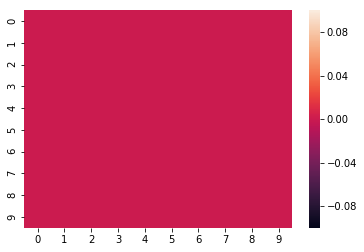

In [14]:
import seaborn as sns
ax = sns.heatmap(sig_mat[0,14000,:th_range,:si_range])#,vmin=np.median(sig_mat))

In [11]:
import seaborn as sns
for i in range(13):
    ax = sns.heatmap(sig_mat[i,:th_range,:si_range])#,vmax=np.median(sig_mat))
    figure = ax.get_figure()    
    figure.savefig('subc'+str(i)+'.png', dpi=400)
    figure.clear()

ValueError: Must pass 2-d input

In [ ]:
red_smat =  skimage.measure.block_reduce(sig_mat, (1,2,2), np.mean) 
ax = sns.heatmap(red_smat[0,:th_range,:si_range])#,vmin=np.median(sig_mat))

In [ ]:
target_sig.shape

In [ ]:
target_sig.shape

In [ ]:
sig_mat[0,0]

In [ ]:
a = calc_p(target_sig[:,subc,:,:],r,8,theta,sigma) 

In [ ]:
a[:10]

In [ ]:
np.abs(a)[:10]